<a href="https://colab.research.google.com/github/AlmaBasic/Artificial-intelligence/blob/main/GANS_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# -----------------------
# Hyperparameters
# -----------------------
latent_dim = 100
batch_size = 128
epochs = 25
lr = 0.0002

In [4]:
# -----------------------
# Dataset
# -----------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
# -----------------------
# Generator
# -----------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),

            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# -----------------------
# Discriminator
# -----------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
# -----------------------
# Visualization
# -----------------------
fixed_z = torch.randn(16, latent_dim).to(device)

def show_images(epoch):
    G.eval()
    with torch.no_grad():
        fake = G(fixed_z).view(-1, 28, 28)
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake[i].cpu(), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Epoch {epoch}")
    plt.show()
    G.train()

Epoch 1/25 | D loss: 1.277 | G loss: 0.764
Epoch 2/25 | D loss: 1.508 | G loss: 2.059
Epoch 3/25 | D loss: 1.103 | G loss: 1.360
Epoch 4/25 | D loss: 1.649 | G loss: 3.372
Epoch 5/25 | D loss: 1.175 | G loss: 1.289


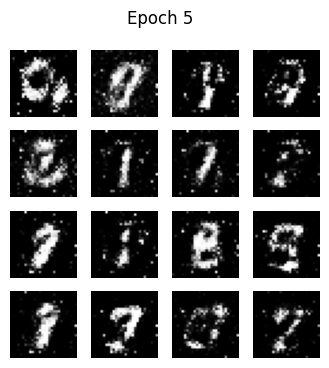

Epoch 6/25 | D loss: 1.244 | G loss: 1.011
Epoch 7/25 | D loss: 1.345 | G loss: 1.785
Epoch 8/25 | D loss: 1.256 | G loss: 0.889
Epoch 9/25 | D loss: 1.336 | G loss: 1.445
Epoch 10/25 | D loss: 1.236 | G loss: 1.468


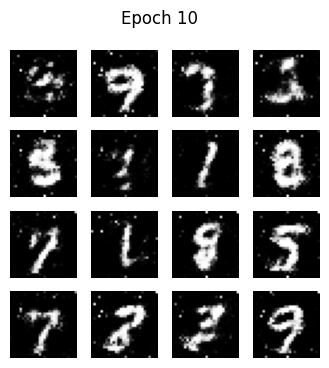

Epoch 11/25 | D loss: 1.270 | G loss: 1.367
Epoch 12/25 | D loss: 1.264 | G loss: 1.043
Epoch 13/25 | D loss: 1.286 | G loss: 1.055
Epoch 14/25 | D loss: 1.264 | G loss: 1.101
Epoch 15/25 | D loss: 1.250 | G loss: 0.997


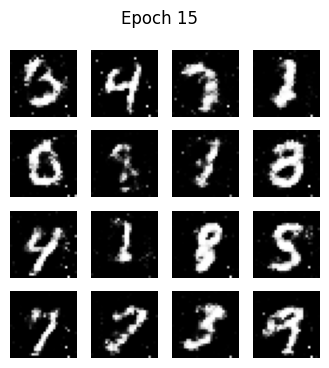

Epoch 16/25 | D loss: 1.222 | G loss: 1.202
Epoch 17/25 | D loss: 1.240 | G loss: 0.894
Epoch 18/25 | D loss: 1.226 | G loss: 1.031
Epoch 19/25 | D loss: 1.315 | G loss: 1.031
Epoch 20/25 | D loss: 1.337 | G loss: 1.052


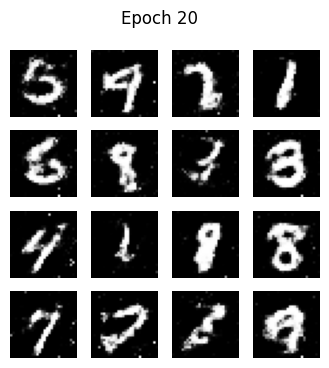

Epoch 21/25 | D loss: 1.289 | G loss: 0.843
Epoch 22/25 | D loss: 1.338 | G loss: 0.744
Epoch 23/25 | D loss: 1.320 | G loss: 0.820
Epoch 24/25 | D loss: 1.308 | G loss: 0.858
Epoch 25/25 | D loss: 1.315 | G loss: 0.824


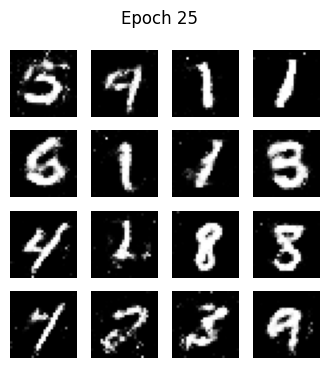

In [7]:
# -----------------------
# Training
# -----------------------
for epoch in range(epochs):
    for real, _ in loader:
        real = real.view(real.size(0), -1).to(device)
        batch = real.size(0)

        # --- Train Discriminator ---
        z = torch.randn(batch, latent_dim).to(device)
        fake = G(z)

        real_labels = torch.ones(batch, 1).to(device) * 0.9
        fake_labels = torch.zeros(batch, 1).to(device)

        loss_D = (
            criterion(D(real), real_labels) +
            criterion(D(fake.detach()), fake_labels)
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --- Train Generator ---
        loss_G = criterion(D(fake), torch.ones(batch, 1).to(device))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs} | D loss: {loss_D.item():.3f} | G loss: {loss_G.item():.3f}")

    if (epoch + 1) % 5 == 0:
        show_images(epoch + 1)